## Import Libraries

In [118]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [119]:
df = pd.read_csv("clear_data.csv")

In [120]:
df.drop('Unnamed: 0' ,axis=1,inplace=True)

In [121]:
df.shape

(6529, 17)

In [122]:
df.head(2)

,team,position,height,age,appearance,goals,assists,red cards,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,Manchester United,Defender Left-Back,178,27,74,0.015374,0.169115,0.0,0.0,5854,443,70,4,35000000,42000000,2,1
1,Manchester United,Defender Left-Back,169,23,89,0.012619,0.063096,0.0,0.0,7132,182,15,3,22000000,22000000,2,1


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [123]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,team,position,height,age,appearance,goals,assists,red cards,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [124]:
# Completeness
df.isnull().sum()

team                0
position            0
height              0
age                 0
appearance          0
goals               0
assists             0
red cards           0
clean sheets        0
minutes played      0
days_injured        0
games_injured       0
award               0
current_value       0
highest_value       0
position_encoded    0
winger              0
dtype: int64

In [125]:
# Accurecy types
df.dtypes

team                 object
position             object
height                int64
age                   int64
appearance            int64
goals               float64
assists             float64
red cards           float64
clean sheets        float64
minutes played        int64
days_injured          int64
games_injured         int64
award                 int64
current_value         int64
highest_value         int64
position_encoded      int64
winger                int64
dtype: object

In [126]:
categorical_features = [ 'team','position']
numeric_features = ['height', 'age', 'appearance','goals', 'assists', 'yellow cards','second yellow cards', 'red cards', 'goals conceded','clean sheets', 'minutes played','days_injured','games_injured','award','current_value','highest_value','position_encoded','winger']

In [127]:
for i in categorical_features:
    print (df[i].value_counts())

team
Royal AM FC               30
Al-Batin FC               28
Gangwon FC                28
Daejeon Hana Citizen      28
Jeonbuk Hyundai Motors    28
                          ..
Swansea City              12
Manchester City           11
Paris Saint-Germain       11
Gaziantep FK               5
Hatayspor                  5
Name: count, Length: 374, dtype: int64
position
Attack Centre-Forward         1294
midfield-CentralMidfield      1106
midfield-DefensiveMidfield     867
Defender Left-Back             774
midfield-AttackingMidfield     745
Attack-RightWinger             695
Attack-LeftWinger              694
midfield-RightMidfield          97
midfield-LeftMidfield           97
Attack-SecondStriker            62
midfield                        58
Attack                          40
Name: count, dtype: int64


#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [128]:
df.head(2)

,team,position,height,age,appearance,goals,assists,red cards,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,Manchester United,Defender Left-Back,178,27,74,0.015374,0.169115,0.0,0.0,5854,443,70,4,35000000,42000000,2,1
1,Manchester United,Defender Left-Back,169,23,89,0.012619,0.063096,0.0,0.0,7132,182,15,3,22000000,22000000,2,1


In [129]:
categorical_features

['team', 'position']

In [130]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features,drop_first=1)

In [131]:
df.shape

(6529, 399)

In [132]:
df.head(2)

,height,age,appearance,goals,assists,red cards,clean sheets,minutes played,days_injured,games_injured,...,position_Attack-LeftWinger,position_Attack-RightWinger,position_Attack-SecondStriker,position_Defender Left-Back,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,178,27,74,0.015374,0.169115,0.0,0.0,5854,443,70,...,False,False,False,True,False,False,False,False,False,False
1,169,23,89,0.012619,0.063096,0.0,0.0,7132,182,15,...,False,False,False,True,False,False,False,False,False,False


In [133]:
encoder = LabelEncoder()
df['current_value'] = encoder.fit_transform(df['current_value'])  

#### 3. Feature selection

In [134]:
# sns.heatmap(df.corr(), annot=True);

In [135]:
correlation = df.corr(numeric_only=True)
#print(correlation['Price'].sort_values(ascending=False))
print(correlation['current_value'].sort_values(ascending=False))

current_value        1.000000
highest_value        0.667798
appearance           0.569619
minutes played       0.560673
award                0.307235
                       ...   
team_Al-Batin FC    -0.072296
team_Swallows FC    -0.074581
team_Royal AM FC    -0.078198
position_midfield   -0.121034
clean sheets              NaN
Name: current_value, Length: 399, dtype: float64


In [136]:
# Set the correlation threshold
threshold = 0.7  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value']) > threshold]['current_value'].index
selected_features

Index(['current_value'], dtype='object')

In [137]:
df = df[selected_features]
df.head()

,current_value
0,103
1,94
2,82
3,109
4,97


#### 4. Prepare train and test data

In [139]:
# Prepare data
X = df.drop(['current_value'], axis=1)
y = df['current_value']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X.shape

(6529, 7)

## Buliding the Model

In [ ]:
model = LogisticRegression()

## Train the Model

In [ ]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LogisticRegression()

## Test the Model

In [ ]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Interpretation of the Model

In [ ]:
# Each row of the model.coef_ matrix tells you how each feature affects being in the corresponding class versus any other class
coeff_df = pd.DataFrame(model.coef_[2],X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
appearance,-0.221409
assists,-0.090063
minutes played,-1.652198
days_injured,-0.124788
games_injured,-0.037495
award,-0.844317
highest_value,-4.318953


In [ ]:
model.coef_

array([[-2.59687732e+00, -4.72402455e-01, -1.71388793e-01,
        -2.44433010e-01, -8.83839780e-01, -1.21708999e+00,
        -5.00070726e+00],
       [-2.36320112e+00, -1.92951699e-01,  7.12864114e-03,
         2.77360314e-01, -1.22062628e+00, -1.04989615e+00,
        -6.36851158e+00],
       [-2.21408535e-01, -9.00630563e-02, -1.65219801e+00,
        -1.24787964e-01, -3.74948733e-02, -8.44317474e-01,
        -4.31895342e+00],
       [-7.66094382e-01, -1.50973111e-01, -6.34515774e-01,
         3.07711287e-01, -6.20122141e-01, -1.46490642e-01,
        -5.72061997e+00],
       [-3.66139841e-01, -8.42996468e-02, -1.39146938e+00,
         3.29636611e-02, -3.90598768e-01, -1.25253041e-01,
        -2.99542283e+00],
       [-2.35035832e-01, -4.37107113e-02, -1.30013302e+00,
        -1.55157657e-01, -3.33843300e-02,  1.44229554e-01,
        -3.69682791e+00],
       [-2.71048189e-01, -2.40940904e-01, -1.26503461e+00,
         3.92316417e-01, -5.75203379e-01,  5.03243841e-01,
        -2.3085070

In [ ]:
print(model.intercept_) 

[-1.19335652 -0.58651871  0.69524979  1.11815992  0.857719    2.00486919
  1.23496631  2.21816854  0.79731604  2.2140031   0.9144552   2.83530869
  0.63988999  2.14857172  1.17486845  2.86880893  0.78432427  1.9766347
  0.46272229  3.13225874 -0.5259315   1.62194262 -0.65418183  3.08647056
 -1.56898949  1.70734796 -1.3932868   3.21749374 -0.63082239  1.98905501
  3.29298552  1.406057   -1.4166202   2.33174493 -0.05812878  3.99120673
  0.68057861  3.49910447  1.6006924   1.07162515  4.00737289  0.70825
  1.70808755  2.95077731 -0.99383811  4.13247455 -1.42377352  1.74976423
  0.57118984  0.2036296   3.86679015 -0.89759346  0.27861657  1.93363122
  3.79363675 -0.41515113 -2.59520388 -1.72449457  3.33864606 -1.7825884
  0.26070848  3.54578387 -1.08756295 -1.81358016 -2.57012793  2.19981491
 -0.8828349  -1.19086704  3.32040585  1.2873038  -1.77657051  3.16333365
  1.76227872  2.54301634  0.69409219  2.52374434  0.65028571  2.07704664
 -2.71605087  2.0027586   0.62287013  2.17023228  0.5170

## Evaluating the Model 

In [ ]:
# our benchmark model
base_model = round(df['current_value'].value_counts()[1]/df.shape[0]*100, 2)
base_model

3.58

1. Accuracy

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.08652373660030628

In [ ]:
y_pred_train = model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred_train)
accuracy

0.09496457974344247

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[ 0, 17,  0, ...,  0,  0,  0],
       [ 0, 39,  0, ...,  0,  0,  0],
       [ 0, 13,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  1,  0,  0]])

ValueError: The number of FixedLocator locations (99), usually from a call to set_ticks, does not match the number of labels (117).

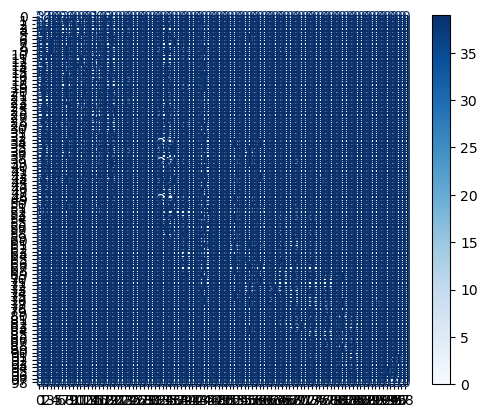

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculate Precision
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.02


In [ ]:
# Calculate Recall
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.03


In [ ]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.02
